# Estimate the Verwey transition temperature

This notebook demonstrates how to estimate the temperature of the Verwey transition from remanence upon warming curves developed through MPMS experiments.

## Import scientific python libraries

Run the cell below to import the functions needed for the notebook.

In [1]:
import pmagpy.rockmag as rmag
import pmagpy.contribution_builder as cb
import pmagpy.ipmag as ipmag

import pandas as pd
pd.set_option('display.max_columns', 500)

%config InlineBackend.figure_format = 'retina'

## Import data

We can take the same approach as in the `rockmag_data_unpack.ipynb` notebook to bring the MagIC data into the notebook as a Contribution. To bring in a different contribution, set the directory path (currently `'./example_data/ECMB'`) and the name of the file (currently `'ECMB 2018.TXT'`) to be those relevant to your data.

In [4]:
# set the dir_path to the directory where the measurements.txt file is located
dir_path = '../example_data/ECMB'

# set the name of the MagIC file
ipmag.unpack_magic('magic_contribution_20213.txt', 
                     dir_path = dir_path,
                     input_dir_path = dir_path,
                     print_progress=False)

# create a contribution object from the tables in the directory
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df

1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/contribution.txt
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/locations.txt
90  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/sites.txt
312  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/samples.txt
1574  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/specimens.txt
17428  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/measurements.txt


## Background on the Verwey transition

The example data used here was collected from mafic dikes in the East Central Minnesota batholith and the specimens exhibit a significant loss of remanence across the Verwey transition. The Verwey transition as defined by Jackson and Moskowitz ([2020](https://doi.org/10.1093/gji/ggaa516)) is:

> The Verwey transition is a reorganization of the magnetite crystal structure occurring at a temperature T<sub>V</sub> in the range 80–125 K, where the room-temperature cubic inverse-spinel structure transforms to a monoclinic arrangement, and many physical properties of the mineral (e.g. electrical resistivity, heat capacity, magnetic susceptibility, remanence and coercivity) change significantly.

It is of interest to determine the Verwey transition temperature (T<sub>V</sub>) as it is highly sensitive to changes in magnetite stoichiometry associated with cation substitution or oxidation.

### Estimating the Verwey transition temperature

It is preferable to estimate the temperature of the Verwey transition (T<sub>V</sub>) associated with warming curves (e.g. the FC/ZFC data) than cooling curves. The rationale is that cooling curves also pass through the isotropic point at a temperature of ∼130 K prior to going through the Verwey transition. The loss of magnetization associated with going through the isotropic point can be very large (particularly for multidomain magnetites) which can obscure the Verwey transition ([Jackson and Moskowitz, 2020](https://doi.org/10.1093/gji/ggaa516)).

We can apply the method described in Jackson and Moskowitz ([2020](https://doi.org/10.1093/gji/ggaa516)) to estimate the temperature of the Verwey transition. In this method, 

> [This approach] assumes that the loss of remanence on warming is due to the superposition of (1) progressive unblocking over the 20–300 K temperature range [e.g. due to the transition from the stable single-domain (SSD) to the superparamagnetic (SP) state in nanoparticle populations of magnetite or other magnetic phases] and (2) domain reorganization and intraparticle remanence rotation in a discrete temperature window around T<sub>V</sub>, due to the monoclinic-to-cubic transformation in magnetite.

The method to estimate the temperature of the Verwey transition of Jackson and Moskowitz ([2020](https://doi.org/10.1093/gji/ggaa516)) is to fit the derivative of the data outside of the Verwey transition and then subtract that fit from the derivative. This approach seeks to isolate the signal that is due to the Verwey transition. The peak of the derivative curve can then be used to estimate T<sub>V</sub>. This is done as the interpolated zero-crossing of the derivative of the spectrum curve.

In the code cell below, we define the temperature and magnetization values that will be used for estimating T<sub>V</sub>. The following parameters can be adjusted:

`t_range_background_min` and `t_range_background_max`: The temperature range over which the polynomial fit is applied to the background
`excluded_t_min` and `excluded_t_max`: The temperature range that is excluded from the background fit due to remanence loss associated with the Verwey transition.
`poly_deg`: the degree of the polynomial fit that is made to the background. Following Jackson and Moskowitz ([2020](https://doi.org/10.1093/gji/ggaa516)), the default is set to be 3 (cubic).

As described in Jackson and Moskowitz ([2020](https://doi.org/10.1093/gji/ggaa516)), these temperature ranges and polynomial degree can be adjusted to obtain ‘reasonable’ looking curves for the magnetite demagnetization and the progressive unblocking. The goal is for curves that are monotonic with and fits that are within the measurement noise, while seeking to minimizing the polynomial degree.

## Interactively fit the Verwey transition

First we need to pick the specimen and the experiment (FC or ZFC curve) to analyze.

In [5]:
specimen_dropdown, method_dropdown = rmag.interactive_verwey_specimen_method_selection(measurements)

Once a sample is selected, we can estimate the Verwey transition using the method described above. Adjust the sliders to change the range of the background that is being fit, the temperature range that is being excluded from the background fit, and the polynomial degree that is being used for the background fit. 

*Note: if you change the specimen or method in the dropdown menus above, rerun the code in the cell below to do the fit for the new specimen.*

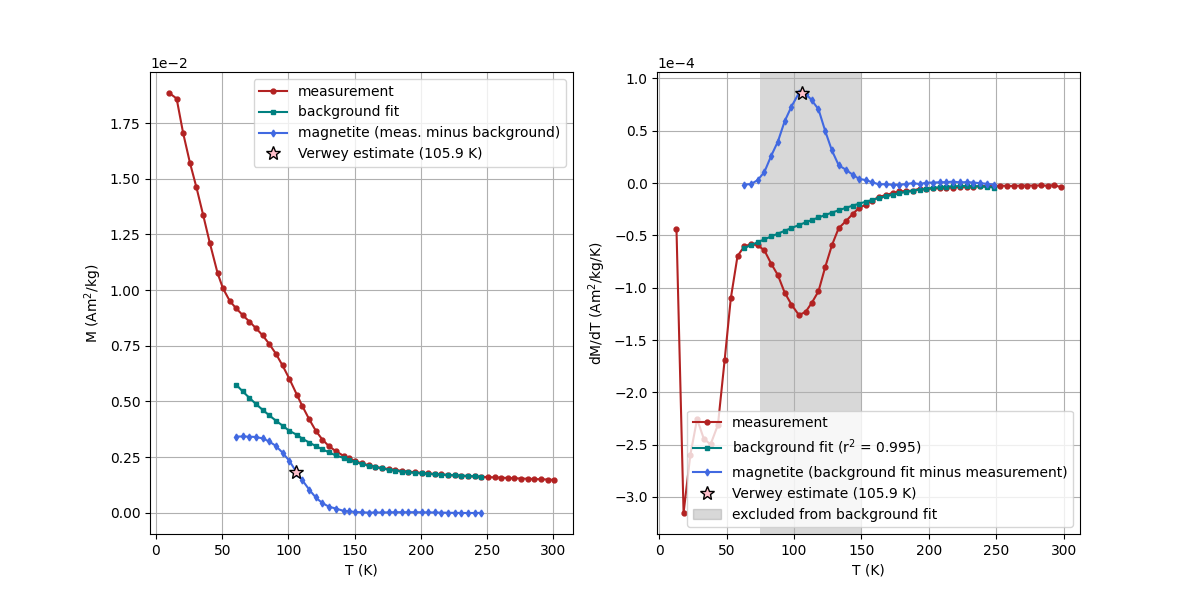

In [6]:
%matplotlib widget
rmag.interactive_verwey_estimate(measurements, specimen_dropdown, method_dropdown)

## Use the `rmag.verwey_estimate` function

The interactive widgets above are using the function `rmag.verwey_estimate`. Rather than putting in the values using the interactive widgets, they can be specified and passed to the function. This approach is being taken in the code cell below.

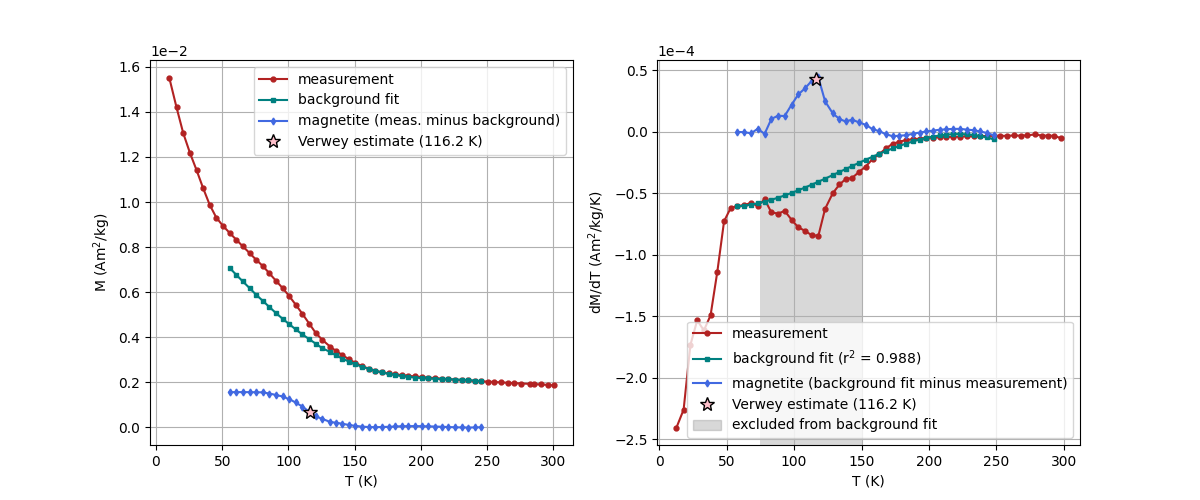

In [7]:
specimen_name = 'NED2-8c'
fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data_dc(measurements, specimen_name)
temps = fc_data['meas_temp']
mags = fc_data['magn_mass']

#Enter the minimum temperature for the background fit
t_range_background_min = 55 

#Enter the maximum temperature for the background fit
t_range_background_max = 250 

#Enter the minimum temperature to exclude from the background fit
excluded_t_min = 75 

#Enter the maximum temperature to exclude from the background fit
excluded_t_max = 150 

#The polynomial degree for the background fit can be adjusted (default is 3)
poly_deg = 3

verwey_estimate, remanence_loss = rmag.verwey_estimate(temps, mags, 
                                       t_range_background_min,
                                       t_range_background_max,
                                       excluded_t_min,
                                       excluded_t_max,
                                       poly_deg)

## Plot the second derivative curve

The estimate of the Verwey transition calculated above uses second derivative and calculates where the second derivative crosses zero by interpolating from the points on either side of the peak in the first derivative. This calculation can be visualized by setting the parameter `plot_zero_crossing = True` which generates an additional plot.

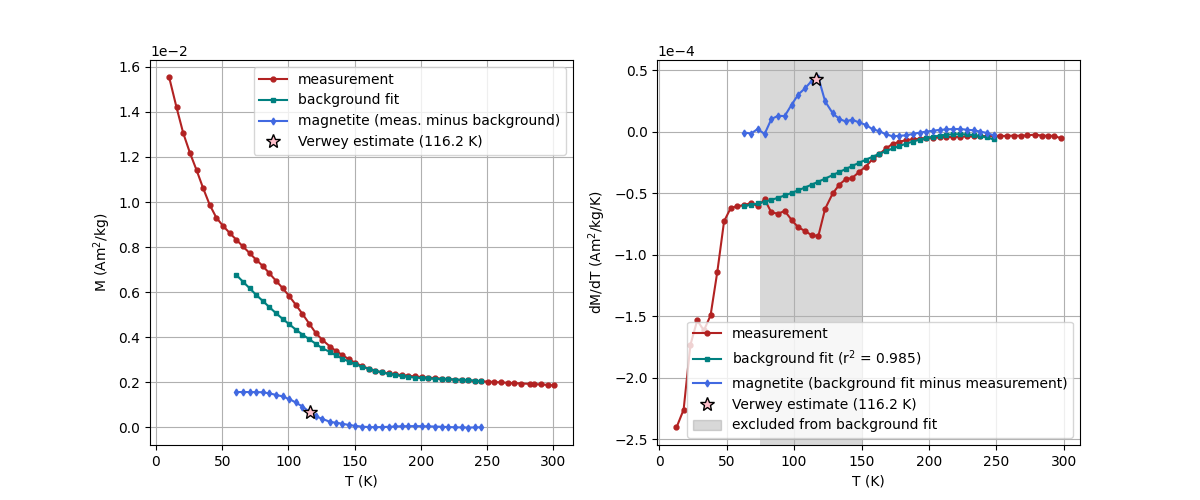

In [8]:
specimen_name = 'NED2-8c'
fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data_dc(measurements, specimen_name)
temps = fc_data['meas_temp']
mags = fc_data['magn_mass']

verwey_estimate, remanence_loss = rmag.verwey_estimate(temps, mags, 
                                       t_range_background_min=60,
                                       t_range_background_max=250,
                                       excluded_t_min=75,
                                       excluded_t_max=150,
                                       poly_deg=3,
                                       plot_zero_crossing = True)

## Determine and record the Verwey temperatures for multiple specimens

There are three specimens with LT-SIRM data. Let's plot the data for each specimen and estimate the Verwey temperature for each. We want to be able to record all of the parameters along with the estimated Verwey transition.

We will take the following approach:
- define a list of dictionaries each containing the specimen name and its parameters for the fit (more specimens code be added by making additional dictionaries within the list). (*Note that if you use the ZFC experiment rather than the FC, the method code should be changed to LP-ZFC. SM-1DMAX denotes that the peak of the first derivative was used to make the fit*).
- go through each specimen and make the fit using the `rmag.verwey_estimate() function` while recording the parameters and the estimated temperature.
- make the recorded parameters into a Dataframe

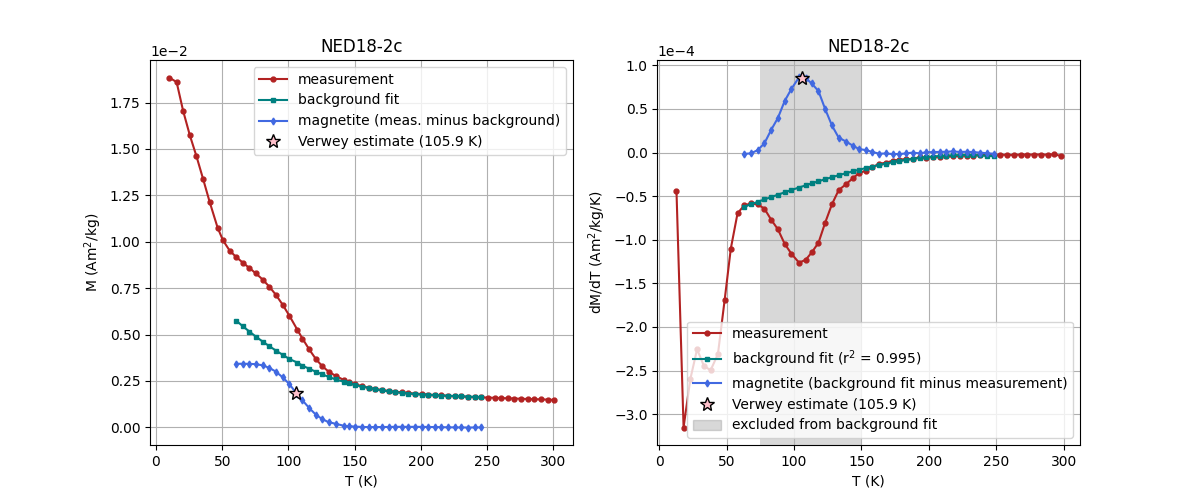

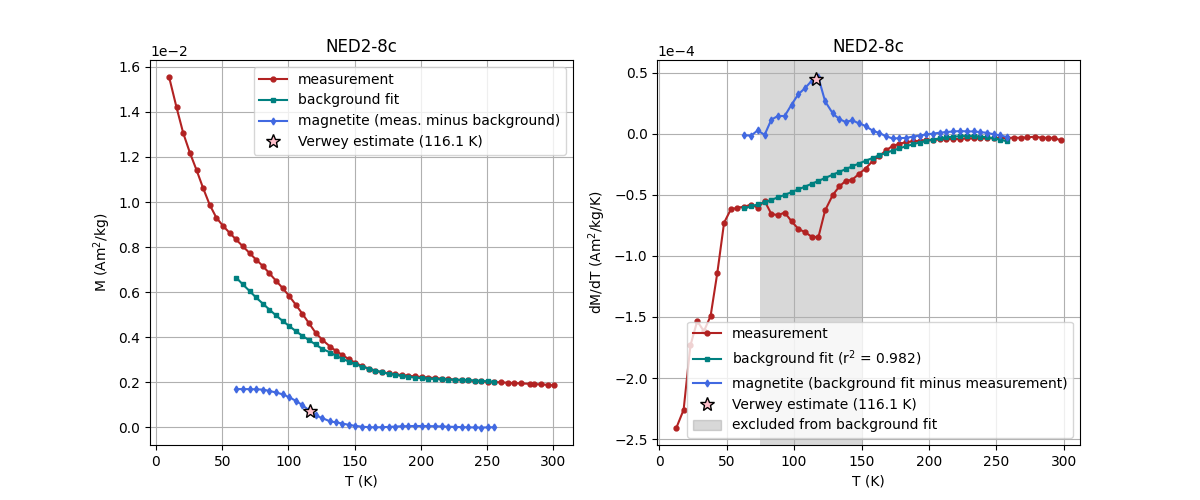

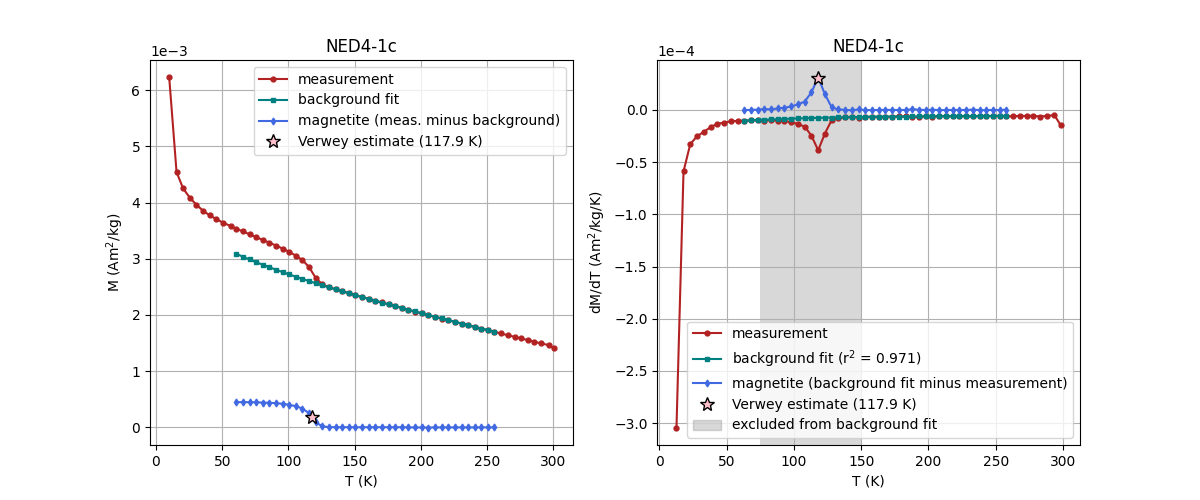

In [9]:
# Define a list of dictionaries, each containing the specimen name and its unique parameters
specimens_with_params = [
    {
        'specimen_name': 'NED18-2c',
        'params': {
            't_range_background_min': 60,
            't_range_background_max': 250,
            'excluded_t_min': 75,
            'excluded_t_max': 150,
            'poly_deg': 3,
            'method_codes': 'SM-1DMAX:LP-FC'
        }
    },
    {
        'specimen_name': 'NED2-8c',
        'params': {
            't_range_background_min': 60,
            't_range_background_max': 260,
            'excluded_t_min': 75,
            'excluded_t_max': 150,
            'poly_deg': 3,
            'method_codes': 'SM-1DMAX:LP-FC'
        }
    },
    {
        'specimen_name': 'NED4-1c',
        'params': {
            't_range_background_min': 60,
            't_range_background_max': 260,
            'excluded_t_min': 75,
            'excluded_t_max': 150,
            'poly_deg': 3,
            'method_codes': 'SM-1DMAX:LP-FC'
        }
    }
]

# Initialize an empty list to store Verwey transition estimates along with parameters
verwey_estimates_and_params = []

# Process each specimen with its unique parameters
for specimen in specimens_with_params:
    specimen_name = specimen['specimen_name']
    params = specimen['params']
    
    fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data_dc(measurements, specimen_name)
    temps = fc_data['meas_temp']
    mags = fc_data['magn_mass']
    
    verwey_estimate, rem_loss = rmag.verwey_estimate(temps, mags, 
                                           t_range_background_min=params['t_range_background_min'],
                                           t_range_background_max=params['t_range_background_max'],
                                           excluded_t_min=params['excluded_t_min'],
                                           excluded_t_max=params['excluded_t_max'],
                                           poly_deg=params['poly_deg'],
                                           plot_title=specimen_name)
    # Append the specimen name, Verwey estimate, and all parameters to the list
    record = {'specimen': specimen_name, 'critical_temp': verwey_estimate, 
              'critical_temp_type': 'Verwey'}
    record.update(params)  # Merge the parameters with the record
    verwey_estimates_and_params.append(record)
    
verwey_estimates = pd.DataFrame(verwey_estimates_and_params)

We can now have a look at Verwey estimate that have been recorded:

In [10]:
verwey_estimates

,specimen,critical_temp,critical_temp_type,t_range_background_min,t_range_background_max,excluded_t_min,excluded_t_max,poly_deg,method_codes
0,NED18-2c,105.861068,Verwey,60,250,75,150,3,SM-1DMAX:LP-FC
1,NED2-8c,116.145701,Verwey,60,260,75,150,3,SM-1DMAX:LP-FC
2,NED4-1c,117.902959,Verwey,60,260,75,150,3,SM-1DMAX:LP-FC


## Add these Verwey estimates to the specimens MagIC table

Having computed the Verwey transition estimates (and captured the fitting parameters) for each specimen, we now want to record those results alongside the rest of our specimen metadata in the MagIC “specimens” table. The following loop does this in a few stages:

1. **Iterate over every Verwey-fit result**  
   We step through the list `verwey_estimates_and_params`, where each element is a dict containing the specimen name, the Verwey estimate itself, and all of the fit parameters we used.

2. **Build a human-readable description string**  
   We create a new `description` field for each entry that notes:  
   > “calculated using MPMS_verwey_fit.ipynb with parameters …”  
   We then append the specific numerical values of the fit (e.g. the temperature ranges, polynomial degree) so that anyone inspecting the table later can immediately see exactly how that Verwey estimate was obtained.

3. **Clean up the dict**  
   Once those key–value pairs have been folded into the `description`, we remove them from the top-level of the dict so that only the final summary string remains in the table column (and we avoid redundant columns).

4. **Fetch the matching sample & weight from the existing specimens table**  
   To maintain the MagIC convention, each specimen row must also carry its associated sample name and mass. We look those up by matching on the `specimen` identifier in our `specimens` DataFrame.

5. **Insert the new row into the MagIC table**  
   Finally, we call the table’s `add_row()` method, passing the specimen name and our enriched dict. This appends a fully-populated row (with Verwey estimate, description, sample, weight, etc.) into the MagIC “specimens” table.

In [11]:
for n in range(0,len(verwey_estimates_and_params)):

    entry = verwey_estimates_and_params[n]
    
    entry['description'] = 'calculated using MPMS_verwey_fit.ipynb with parameters'
    
    # Specify the keys to append to the description and then remove
    keys_to_include = [
        't_range_background_min',
        't_range_background_max',
        'excluded_t_min',
        'excluded_t_max',
        'poly_deg',
    ]

    # Update the description by appending selected key-value pairs
    for key in keys_to_include:
        entry['description'] += f', {key}: {entry[key]}'

    # Remove the keys that were added to the description
    for key in keys_to_include:
        del entry[key]
     
    df = contribution.tables['specimens'].df
    sample = df.loc[df['specimen'] == entry['specimen'], 'sample'].iloc[0]
    weight = df.loc[df['specimen'] == entry['specimen'], 'weight'].iloc[0]
    entry['sample'] = sample
    entry['weight'] = weight
    
    contribution.tables['specimens'].add_row(entry['specimen'],verwey_estimates_and_params[n])


In [12]:
contribution.tables['specimens'].df

,citations,critical_temp,critical_temp_type,description,dir_comp,dir_dang,dir_dec,dir_inc,dir_mad_free,dir_n_comps,dir_n_measurements,dir_tilt_correction,experiments,hyst_bc,hyst_bc_offset,hyst_bcr,hyst_mr_mass,hyst_ms_mass,hyst_xhf,instrument_codes,int_corr,meas_orient_phi,meas_orient_theta,meas_step_max,meas_step_min,meas_step_unit,meas_temp,method_codes,rem_hirm_mass,rem_sratio,rem_sratio_back,rem_sratio_forward,result_quality,sample,software_packages,specimen,volume,weight
specimen name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NED1-1b,This study,NaN,None,None,mc,2.8,159.7,62.5,1.0,1.0,5.0,-1.0,NED1-1b_LP-DIR-AF,NaN,NaN,NaN,NaN,NaN,NaN,hargrave 2018-09-21 18:45:36,u,NaN,NaN,0.04,0.025,T,NaN,LP-DIR-AF:DE-BFL:DA-DIR,NaN,NaN,NaN,NaN,g,NED1-1,pmagpy-4.2.25: demag_gui,NED1-1b,NaN,NaN
NED1-1b,This study,NaN,None,None,mc,2.8,139.2,74.1,1.0,1.0,5.0,0.0,NED1-1b_LP-DIR-AF,NaN,NaN,NaN,NaN,NaN,NaN,hargrave 2018-09-21 18:45:36,u,NaN,NaN,0.04,0.025,T,NaN,LP-DIR-AF:DE-BFL:DA-DIR-GEO,NaN,NaN,NaN,NaN,g,NED1-1,pmagpy-4.2.25: demag_gui,NED1-1b,NaN,NaN
NED1-1b,This study,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,NaN,LP-NOMAG,NaN,NaN,NaN,NaN,None,NED1-1,None,NED1-1b,NaN,NaN
NED1-2b,This study,NaN,None,None,mc,3.4,164.1,66.9,0.4,1.0,7.0,-1.0,NED1-2b_LP-DIR-AF,NaN,NaN,NaN,NaN,NaN,NaN,hargrave 2018-09-21 19:30:31,u,NaN,NaN,0.04,0.020,T,NaN,LP-DIR-AF:DE-BFL:DA-DIR,NaN,NaN,NaN,NaN,g,NED1-2,pmagpy-4.2.25: demag_gui,NED1-2b,NaN,NaN
NED1-2b,This study,NaN,None,None,mc,3.4,149.9,76.3,0.4,1.0,7.0,0.0,NED1-2b_LP-DIR-AF,NaN,NaN,NaN,NaN,NaN,NaN,hargrave 2018-09-21 19:30:31,u,NaN,NaN,0.04,0.020,T,NaN,LP-DIR-AF:DE-BFL:DA-DIR-GEO,NaN,NaN,NaN,NaN,g,NED1-2,pmagpy-4.2.25: demag_gui,NED1-2b,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NED18-2c,This study,105.900000,Verwey,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,IRM-BigRed,None,NaN,NaN,NaN,NaN,None,NaN,SM-1DMAX:LP-FC,NaN,NaN,NaN,NaN,None,NED18-2,None,NED18-2c,NaN,NaN
NED18-2c,This study,106.300000,Verwey,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,IRM-BigRed,None,NaN,NaN,NaN,NaN,None,NaN,SM-1DMAX:LP-FC,NaN,NaN,NaN,NaN,None,NED18-2,None,NED18-2c,NaN,NaN
NED18-2c,None,105.861068,Verwey,calculated using MPMS_verwey_fit.ipynb with pa...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,NaN,SM-1DMAX:LP-FC,NaN,NaN,NaN,NaN,None,NED18-2,None,NED18-2c,NaN,0.000254


In [13]:
ipmag.contribution_to_magic(contribution, dir_path=dir_path)

-I- overwriting /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/specimens.txt
-I- 1577 records written to specimens file
-I- overwriting /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/samples.txt
-I- 312 records written to samples file
-I- overwriting /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/sites.txt
-I- 90 records written to sites file
-I- overwriting /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/locations.txt
-I- 1 records written to locations file
-I- overwriting /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/measurements.txt
-I- 17428 records written to measurements file
-I- /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/locations.txt file successfully read in
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/upload.txt
-I- /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/ECMB/locations.txt written to  /Users/yimingzhang/Gi